# 🎦**AlloCiné Data Analysis**📊

We had web scraped the [movies](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Movies_From_AlloCine.ipynb), [series](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Series_From_AlloCine.ipynb), and [ratings](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Ratings_From_AlloCine.ipynb) data from the [AlloCiné](https://www.allocine.fr/) website.

**Data description :**

Features|Movies|Series|Ratings
-------|---------|---------|---
`id`|X|X|-
`title`|X|X|-
`status`|-|X|-
`release_date`|X|X|-
`duration`|X|X|-
`nb_seasons`|-|X|-
`nb_episodes`|-|X|-
`genres`|X|X|-
`directors`|X|X|-
`actors`|X|X|-
`nationality`|X|X|-
`press_rating`|X|X|X
`nb_press_rating`|X|X|-
`spect_rating`|X|X|X
`nb_spect_rating`|X|X|-
`summary`|X|X|-
`poster_link`|X|X|-
`user_id`|-|-|X
`(user/press)_name`|-|-|X
`(movie/series)_id`|-|-|X
`date`|-|-|X


If you are interested in, the data is available on one csv (brut and clean version) [allocine_dataset.zip](http://olivier-maillot.fr/wp-content/uploads/2017/08/allocine_dataset.zip) or in multiple csv files (clean version only) [allocine_rel-dataset.zip](http://olivier-maillot.fr/wp-content/uploads/2017/08/allocine_rel-dataset.zip).

---
# **Import libs**

In [259]:
# import libraries
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os
from warnings import filterwarnings
import missingno as msno

# We ignore reindexing warnings
filterwarnings("ignore",message="Boolean Series key will be reindexed")
%matplotlib inline

# **Data cleaning**

## Saving files

In [260]:
# Save all the dataframes from data in a csv file
def save_data(df: pd.DataFrame, path:str, name: str):
    # We create the folder if not exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(f"{path}{name}.csv", index=False)
    print(f"File successfully saved in {path}{name}.csv")

## Load the csv files

In [261]:
def load_csv():
    '''
    Load the csv file and return a dataframe
    '''
    root_path = "../Saved Data/"
    movies = pd.read_csv(f"{root_path}allocine_movies_100p.csv")
    series = pd.read_csv(f"{root_path}allocine_series_100p.csv")
    press_movies = pd.read_csv(f"{root_path}press_ratings_movies.csv")
    press_series = pd.read_csv(f"{root_path}press_ratings_series.csv")
    user_movies = pd.read_csv(f"{root_path}user_ratings_movies.csv")
    user_series = pd.read_csv(f"{root_path}user_ratings_series.csv")
    return {"movies":movies, "series":series, "press_movies":press_movies, "press_series":press_series, "user_movies":user_movies, "user_series":user_series}
data = load_csv()
movies, series, press_movies, press_series, user_movies, user_series = data["movies"], data["series"], data["press_movies"], data["press_series"], data["user_movies"], data["user_series"]

## Rename and store columns names

In [262]:
# Rename (nb_)spec_rating to (nb_)user_rating
movies.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)
series.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)

In [263]:
# Store columns names
movies_cols = movies.columns
series_cols = series.columns
press_movies_cols = press_movies.columns
press_series_cols = press_series.columns
user_movies_cols = user_movies.columns
user_series_cols = user_series.columns

## Drop duplicates and NaN rating values

In [264]:
m_duplicates = movies.duplicated(subset=["id"]).sum()
s_duplicates = series.duplicated(subset=["id"]).sum()
pm_duplicates = press_movies.duplicated().sum()
ps_duplicates = press_series.duplicated().sum()
um_duplicates = user_movies.duplicated().sum()
us_duplicates = user_series.duplicated().sum()
print(f"Nb of movie duplicates: {m_duplicates}")
print(f"Nb of series duplicates: {s_duplicates}")
print(f"Nb of press movie duplicates: {pm_duplicates}")
print(f"Nb of press series duplicates: {ps_duplicates}")
print(f"Nb of user movie duplicates: {um_duplicates}")
print(f"Nb of user series duplicates: {us_duplicates}")
series.drop_duplicates(subset=["id"], inplace=True, ignore_index=True)
movies.drop_duplicates(subset=["id"], inplace=True, ignore_index=True)
press_movies.drop_duplicates(inplace=True, ignore_index=True)
press_series.drop_duplicates(inplace=True, ignore_index=True)
user_movies.drop_duplicates(inplace=True, ignore_index=True)
user_series.drop_duplicates(inplace=True, ignore_index=True)
print("--> All duplicates removed")

Nb of movie duplicates: 34
Nb of series duplicates: 75
Nb of press movie duplicates: 649
Nb of press series duplicates: 158
Nb of user movie duplicates: 2463
Nb of user series duplicates: 2184
--> All duplicates removed


In [265]:
# Drop series and movies with no press AND no user ratings
m_na_ratings = movies[movies["press_rating"].isna()][movies["user_rating"].isna()].shape[0]
s_na_ratings = series[series["press_rating"].isna()][series["user_rating"].isna()].shape[0]
movies.dropna(subset=["nb_press_rating","nb_user_rating","press_rating","user_rating"], inplace=True, how="all")
series.dropna(subset=["nb_press_rating","nb_user_rating","press_rating","user_rating"], inplace=True, how="all")
print(f"Number of movies with no ratings: {m_na_ratings}")
print(f"Number of series with no ratings: {s_na_ratings}")
print("--> All movies and series with no ratings removed")

Number of movies with no ratings: 1
Number of series with no ratings: 5
--> All movies and series with no ratings removed


## Convert the strings to arrays

In [266]:
def convert_to_array(df: pd.DataFrame):
    '''
    Convert the strings to arrays
    '''
    df["genres"] = df["genres"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["directors"] = df["directors"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["actors"] = df["actors"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["nationality"] = df["nationality"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)

In [267]:
convert_to_array(movies)
convert_to_array(series)
# Convert nb_spec_rating and nb_press_rating to int
#movies[["nb_press_rating","nb_user_rating"]] = movies[["nb_press_rating","nb_user_rating"]].astype(int)
#series[["nb_press_rating","nb_user_rating"]] = series[["nb_press_rating","nb_user_rating"]].astype(int)

## Create new tables

### *GENRE*

#### *Create `genres` dataframes*

In [268]:
def create_genre_df(df_key: str):
    # Get dataframe from key
    df = data.get(df_key)
    genre_df = None
    if df is not None:  
        df = df.copy()      
        # Remove all rows with no genres
        df.dropna(subset=["genres"], inplace=True)
        # Get all unique genres from df
        genres_list = [genre.lstrip() for genres in df["genres"] for genre in genres]
        genres_list = sorted(list(set(genres_list))) 
        # Create dataframe with the number of movies per genre from genres_list
        genre_df = pd.DataFrame({"genres": genres_list, f"nb_{df_key}": [df[df["genres"].apply(lambda x: genre in x).values].shape[0] for genre in genres_list]})

        # Add the average duration per genre
        genre_df["avg_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].mean()) for genre in genres_list]

        # Add the median duration per genre
        genre_df["median_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].median()) for genre in genres_list]

        # Add the nb_press_rating and nb_user_rating to the genre_df
        genre_df["nb_press_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_press_rating"].sum()) for genre in genres_list]
        genre_df["nb_user_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_user_rating"].sum()) for genre in genres_list]

        # Add the total_rating to the genre_df (press_rating + user_rating)
        genre_df["total_rating"] = genre_df["nb_press_rating"] + genre_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the genre_df 
        genre_df["press_rating_percentage"] = round(genre_df["nb_press_rating"] / genre_df["nb_press_rating"].values.sum() * 100, 3)
        genre_df["user_rating_percentage"] = round(genre_df["nb_user_rating"] / genre_df["nb_user_rating"].values.sum() * 100, 3)

        # Add the movies/series_percentage to the genre_df
        genre_df[f"{df_key}_percentage"] = round(genre_df[f"nb_{df_key}"]/df.shape[0] * 100, 3)
        return genre_df.sort_values(by = "genres", ascending = True)

In [269]:
m_genres_df = create_genre_df("movies")
s_genres_df = create_genre_df("series")

In [270]:
print(m_genres_df.genres.values)
print(s_genres_df.genres.values)

['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Comédie'
 'Comédie dramatique' 'Comédie musicale' 'Drame' 'Epouvante-horreur'
 'Erotique' 'Espionnage' 'Famille' 'Fantastique' 'Guerre' 'Historique'
 'Judiciaire' 'Musical' 'Policier' 'Péplum' 'Romance' 'Science fiction'
 'Sport event' 'Thriller' 'Western']
['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Comédie'
 'Comédie dramatique' 'Comédie musicale' 'Dessin animé' 'Documentaire'
 'Drame' 'Epouvante-horreur' 'Erotique' 'Espionnage' 'Famille'
 'Fantastique' 'Guerre' 'Historique' 'Judiciaire' 'Musical' 'Médical'
 'Policier' 'Péplum' 'Romance' 'Science fiction' 'Show' 'Soap'
 'Sport event' 'Thriller' 'Websérie' 'Western']


#### *Save all `genres` dataframes*

In [271]:
path = "../Cleaned Data/"
save_data(m_genres_df, path, "m_genres")
save_data(s_genres_df, path, "s_genres")

File successfully saved in ../Cleaned Data/m_genres.csv
File successfully saved in ../Cleaned Data/s_genres.csv


### *NATIONALITY*

#### *Create `nationality` dataframes*

In [272]:
def create_nationality_df(df_key: str):
    # Get dataframe from key
    df = data.get(df_key)
    nation_df = None
    if df is not None:        
        df = df.copy()
        # Remove all rows with no nationality
        df.dropna(subset=["nationality"], inplace=True)
        # Get all unique nationality from df
        nationality = [nat.lstrip() for nationality in df["nationality"] for nat in nationality]
        nationality = sorted(list(set(nationality))) 
        # Create dataframe with the number of movies per nationality from nationality list
        nation_df = pd.DataFrame({"nationality": nationality, f"nb_{df_key}": [df[df["nationality"].apply(lambda x: nation in x).values].shape[0] for nation in nationality]})

        # Add the nb_press_rating and nb_user_rating to the nation_df
        nation_df["nb_press_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_press_rating"].sum()) for nation in nationality]
        nation_df["nb_user_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_user_rating"].sum()) for nation in nationality]

        # Add the total_rating to the nation_df (press_rating + user_rating)
        nation_df["total_rating"] = nation_df["nb_press_rating"] + nation_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the nation_df 
        nation_df["press_rating_percentage"] = round(nation_df["nb_press_rating"] / nation_df["nb_press_rating"].values.sum() * 100, 4)
        nation_df["user_rating_percentage"] = round(nation_df["nb_user_rating"] / nation_df["nb_user_rating"].values.sum() * 100, 4)

        # Add the movies/series_percentage to the nation_df
        nation_df[f"{df_key}_percentage"] = round(nation_df[f"nb_{df_key}"]/df.shape[0] * 100, 4)
        return nation_df.sort_values(by = "nationality", ascending = True)

In [273]:
m_nationality_df = create_nationality_df("movies")
s_nationality_df = create_nationality_df("series")

#### *Save all `nationality` dataframes*

In [274]:
path = "../Cleaned Data/"
save_data(m_nationality_df, path, "m_nationality")
save_data(s_nationality_df, path, "s_nationality")

File successfully saved in ../Cleaned Data/m_nationality.csv
File successfully saved in ../Cleaned Data/s_nationality.csv


## Check data coherence

In [275]:
def display_stats(df: pd.DataFrame):
    '''
    Display the statistics of a dataframe
    '''
    # Graph of number of missing values by column
    #msno.heatmap(df, cmap="RdYlBu", sort="ascending")
    msno.matrix(df, figsize=(12,8), color=(round(rd.random(),2),round(rd.random(),2),round(rd.random(),2)), sort="descending")
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:      
        missing_values = missing_values / df.shape[0] * 100
        missing_values = missing_values[missing_values > 0]
        missing_values.sort_values(inplace=True)
        plt.figure(figsize=(12, 5))
        plt.title(f"Percentage of missing values in each column")
        sns.barplot(x=missing_values.index, y=missing_values)
        plt.show()
    else:
        print("No missing values in the dataframe")
    df.info()
    return df.describe()

### Series

In [276]:
# Replace the release_date string by the release year as a date 
series["release_date"] = series["release_date"].apply(lambda x: int(re.findall(r"\d{4}", x)[0]))

#### Stats

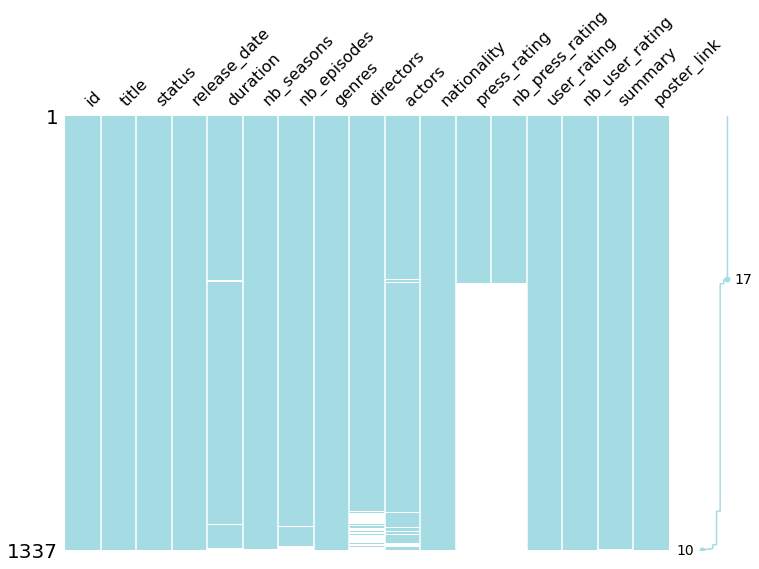

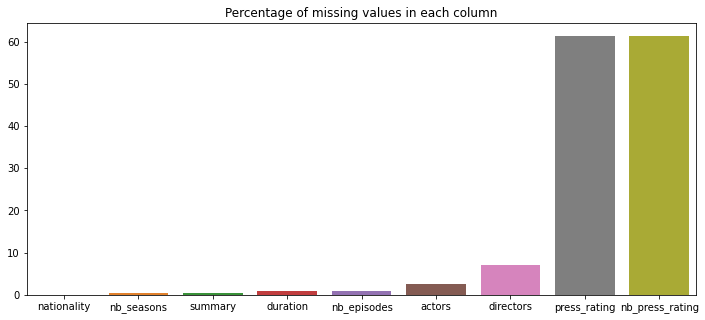

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1341
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1337 non-null   int64  
 1   title            1337 non-null   object 
 2   status           1337 non-null   object 
 3   release_date     1337 non-null   int64  
 4   duration         1324 non-null   float64
 5   nb_seasons       1332 non-null   float64
 6   nb_episodes      1324 non-null   float64
 7   genres           1337 non-null   object 
 8   directors        1243 non-null   object 
 9   actors           1303 non-null   object 
 10  nationality      1336 non-null   object 
 11  press_rating     517 non-null    float64
 12  nb_press_rating  517 non-null    float64
 13  user_rating      1337 non-null   float64
 14  nb_user_rating   1337 non-null   float64
 15  summary          1332 non-null   object 
 16  poster_link      1337 non-null   object 
dtypes: float64(7),

,id,release_date,duration,nb_seasons,nb_episodes,press_rating,nb_press_rating,user_rating,nb_user_rating
count,1337.000000,1337.000000,1324.000000,1332.000000,1324.000000,517.000000,517.000000,1337.000000,1337.000000
mean,18405.789828,2014.798055,45.731118,3.511261,57.027190,3.328820,8.456480,3.594166,3823.077786
std,9108.118180,8.710131,15.121085,4.028340,164.070268,0.598578,3.772162,0.606313,11857.966899
min,4.000000,1965.000000,3.000000,1.000000,1.000000,1.300000,1.000000,0.900000,1.000000
25%,11196.000000,2013.000000,42.000000,1.000000,10.000000,2.900000,6.000000,3.300000,130.000000
50%,21764.000000,2018.000000,45.000000,2.000000,20.000000,3.300000,8.000000,3.700000,495.000000
75%,25130.000000,2020.000000,55.000000,4.000000,53.000000,3.800000,10.000000,4.000000,2158.000000
max,31644.000000,2022.000000,150.000000,52.000000,4573.000000,5.000000,30.000000,4.700000,205979.000000


In [277]:
s_stats = display_stats(series)
s_stats

In [278]:
# Find the series where nb_seasons is greater or equal to nb_episodes 
series[series.nb_seasons >= series.nb_episodes]

,id,title,status,release_date,duration,nb_seasons,nb_episodes,genres,directors,actors,nationality,press_rating,nb_press_rating,user_rating,nb_user_rating,summary,poster_link
45,19874,La Petite Histoire de France,En cours,2015,3.0,4.0,1.0,"[Comédie, Historique]","[Jamel Debbouze, Laurent Tiphaine, Frank Cimière]","[Maxime Gasteuil, David Salles, François Levan...",[France],NaN,NaN,2.9,526.0,"Tout le monde connaît Jeanne d'Arc, Louis XIV ...",https://fr.web.img4.acsta.net/c_310_420/pictur...
1271,9588,Soda,Terminée,2011,3.0,4.0,2.0,[Comédie],"[Frank Bellocq, David Soussan, Kev Adams]","[Kev Adams, Guy Lecluyse, William Lebghil]",[France],NaN,NaN,2.5,3829.0,Fils aîné d’une famille de classe moyenne et m...,https://fr.web.img6.acsta.net/c_310_420/medias...


#### Impute missing duration

In [279]:
def impute_series_missing_duration():
    '''
    From the s_genres_df DataFrame, we order the genres by the number of series with that genre.
    We then compute the median duration of the series with that genre.
    Finally, we impute the missing duration of the series with the median duration of the series with the most popular genre among their genres.
    '''
    # Get the serie with missing duration
    series_na_duration = series[series["duration"].isna()]
    for index, row in series_na_duration.iterrows():
        # Get the genres of each series from the s_genres_df DataFrame
        na_duration_genres = s_genres_df.loc[s_genres_df.genres.isin(row["genres"])]
        # Get the genre with the most series from the na_duration_genres DataFrame
        most_pop_genre = na_duration_genres.sort_values(by = "nb_series", ascending = False).iloc[0]["genres"]
        # Retrieve the median duration of the series with the most popular genre
        median_duration = int(s_genres_df[s_genres_df.genres == most_pop_genre].median_duration)
        # Impute the missing duration of the series with the median duration of the most popular genre
        series.loc[index, "duration"] = median_duration

In [281]:
impute_series_missing_duration()

### Movies

In [372]:
def get_release_season(date: str):
    '''
    Get the release season
    '''
    spring = "03-21"
    summer = "06-21"
    fall = "09-21"
    winter = "12-21"
    my = re.sub(r"\d{4}-", "", date)
    if my < spring or my >= winter:
        return "Winter"
    elif my < summer and my >= spring:
        return "Spring"
    elif my < fall and my >= summer:
        return "Summer"
    elif my < winter and my >= fall:
        return "Fall"

In [373]:
# Keep only the year and the month of the release date
# movies["release_date"] = movies["release_date"].apply(lambda x: x.split("-")[0]+"-"+x.split("-")[1])

# Get the release season
#movies["release_date"] = movies["release_date"].apply(lambda x: get_release_season(x) + " " + x.split("-")[0])


In [375]:
#print(sorted(set(movies.release_date.values),reverse=False))

#### Stats

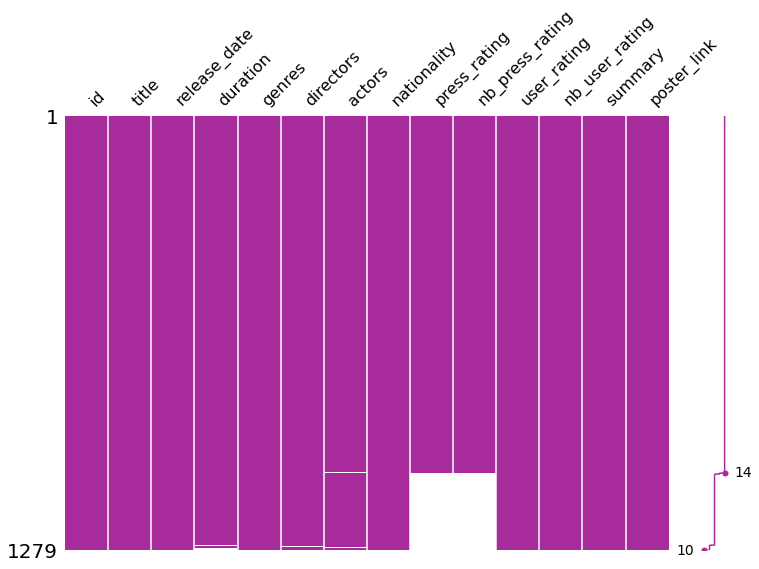

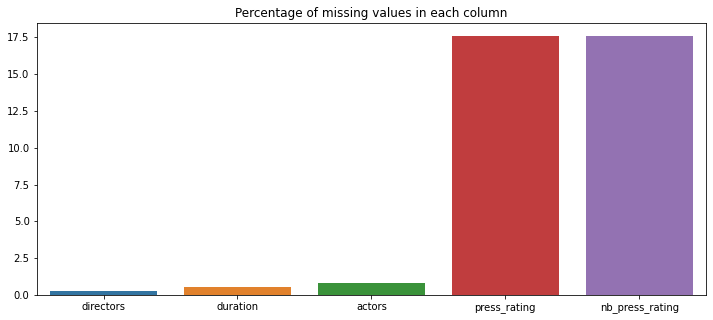

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 0 to 1279
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1279 non-null   int64  
 1   title            1279 non-null   object 
 2   release_date     1279 non-null   object 
 3   duration         1272 non-null   float64
 4   genres           1279 non-null   object 
 5   directors        1276 non-null   object 
 6   actors           1269 non-null   object 
 7   nationality      1279 non-null   object 
 8   press_rating     1054 non-null   float64
 9   nb_press_rating  1054 non-null   float64
 10  user_rating      1279 non-null   float64
 11  nb_user_rating   1279 non-null   float64
 12  summary          1279 non-null   object 
 13  poster_link      1279 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 149.9+ KB


,id,duration,press_rating,nb_press_rating,user_rating,nb_user_rating
count,1279.000000,1272.000000,1054.000000,1054.000000,1279.000000,1279.000000
mean,188883.328382,114.198899,3.366224,20.127135,3.396638,12319.230649
std,100563.100681,22.908992,0.673397,9.372170,0.724518,20302.422318
min,62.000000,40.000000,1.000000,1.000000,0.900000,2.000000
25%,110849.500000,98.000000,2.900000,13.000000,2.900000,616.500000
50%,230689.000000,110.000000,3.400000,21.000000,3.600000,3623.000000
75%,273509.000000,126.000000,3.800000,27.000000,4.000000,15769.500000
max,303108.000000,242.000000,5.000000,45.000000,4.600000,175729.000000


In [376]:
m_stats = display_stats(movies)
m_stats

## Save Cleaned datasets

In [223]:
path = "../Cleaned Data/"
for k,v in data.items():
    save_data(v, path, k)

File successfully saved in ../Cleaned Data/movies.csv
File successfully saved in ../Cleaned Data/series.csv
File successfully saved in ../Cleaned Data/press_movies.csv
File successfully saved in ../Cleaned Data/press_series.csv
File successfully saved in ../Cleaned Data/user_movies.csv
File successfully saved in ../Cleaned Data/user_series.csv


# **Section 1. Ratings Distributions**

## Plot the Distribution of Ratings 

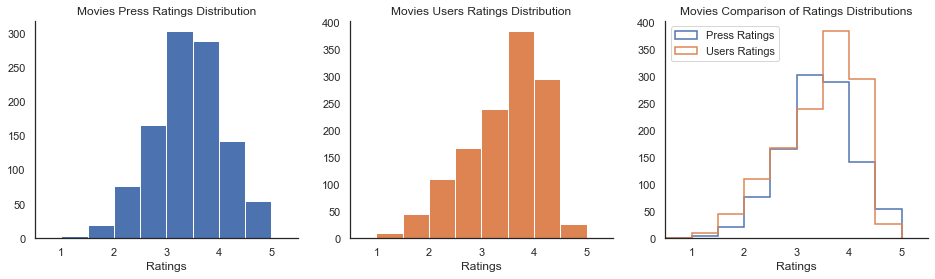

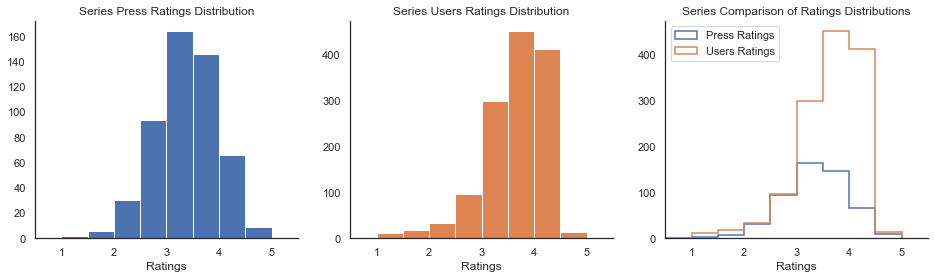

In [224]:
for k,df in list(data.items())[:2]:
    sns.set(style="white", palette="deep")

    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    ax1, ax2, ax3 = fig.axes

    ax1.set_xlim([0.5,5.5])
    ax2.set_xlim([0.5,5.5])
    ax3.set_xlim([0.5,5.5])


    ax1.hist(df["press_rating"], bins = 10, range = (0,5), color='C0') # bin range = 1
    ax1.set_title(f'{k.title()} Press Ratings Distribution')
    ax1.set_xlabel('Ratings')

    ax2.hist(df["user_rating"], bins = 10, range = (0,5), color='C1') # bin range = 1
    ax2.set_title(f'{k.title()} Users Ratings Distribution')
    ax2.set_xlabel('Ratings')

    ax3.hist(df["press_rating"], bins = 10, range = (0,5), histtype = 'step', 
            lw=1.5, label='Press Ratings', color='C0')
    ax3.hist(df["user_rating"], bins = 10, range = (0,5), histtype = 'step', 
            lw=1.5, label='Users Ratings', color='C1')
    ax3.legend(loc = 'upper left')
    ax3.set_title(f'{k.title()} Comparison of Ratings Distributions')
    ax3.set_xlabel('Ratings')

    for ax in fig.axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

In [225]:
# save the fig
#fig.savefig('allocine-0_hist.png', bbox_inches='tight', dpi=200)

## Ratings Correlation

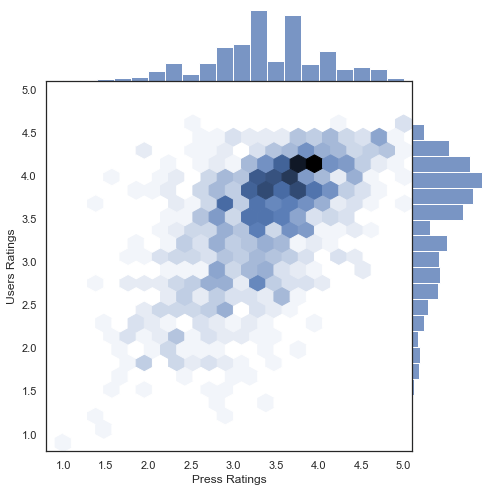

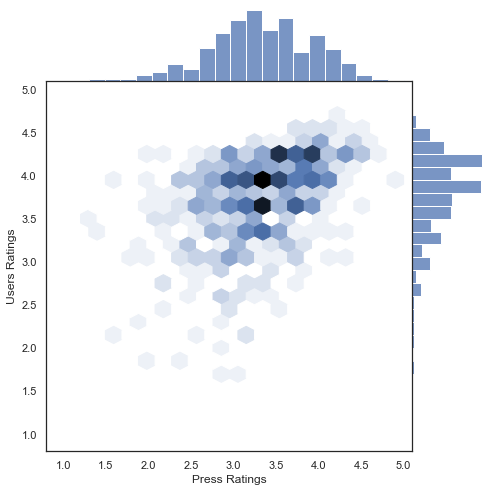

In [226]:
# Correlation between press_rating and user_rating
for k,df in list(data.items())[:2]:
    ax = sns.jointplot(x="press_rating", y="user_rating", 
                    data=df, kind="hex",
                    marginal_kws=dict(bins=20),
                    xlim=(0.8,5.1), ylim=(0.8,5.1),
                    height=7, space=0).set_axis_labels("Press Ratings", "Users Ratings")

In [227]:
# save the fig
#ax.savefig('allocine-1_jointplot.png', bbox_inches='tight', dpi=200)

## Compare to users ratings

five_stars = allocine[allocine["press_rating"] >= 5]
f, ax = plt.subplots(figsize=(15,6))
f.suptitle('Movies with Five Stars From The Press', 
           fontsize=13)
f.subplots_adjust(top=0.85)

sns.countplot(x=five_stars["user_rating"], ax=ax)
ax.set_xlabel("Users Ratings")
ax.set_ylabel("")
sns.despine(top=True, right=True, left=False, bottom=False)

### save the fig
f.savefig('allocine-2_hist5stars.png', bbox_inches='tight', dpi=200)

### # print the first tier and second tier of the Users Ratings
allocine[["user_rating"]].quantile([.33,.66])

p = (len(five_stars[(five_stars["user_rating"] < 2.9)]) / len(five_stars)) * 100
print('{} % of the movies with the highest press ratings received a low users ratings.'.format(round(p, 2)))
p = (len(five_stars[(five_stars["user_rating"] < 3.4) & (five_stars["user_rating"] >= 2.9)]) / len(five_stars)) * 100
print('{} % of the movies with the highest press ratings received a moderate users ratings.'.format(round(p, 2)))
p = (len(five_stars[five_stars["user_rating"] >= 3.4]) / len(five_stars)) * 100
print('{} % of the movies with the highest press ratings received a high users ratings.'.format(round(p, 2)))

# **Section 3. Data Exploration**

## **GENRE**

### *Create `genres` dataframes*

In [254]:
def create_genre_df(df_key: str):
    # Get dataframe from key
    df = data.get(df_key)
    genre_df = None
    if df is not None:  
        df = df.copy()      
        # Remove all rows with no genres
        df.dropna(subset=["genres"], inplace=True)
        # Get all unique genres from df
        genres_list = [genre.lstrip() for genres in df["genres"] for genre in genres]
        genres_list = sorted(list(set(genres_list))) 
        # Create dataframe with the number of movies per genre from genres_list
        genre_df = pd.DataFrame({"genres": genres_list, f"nb_{df_key}": [df[df["genres"].apply(lambda x: genre in x).values].shape[0] for genre in genres_list]})

        # Add the average duration per genre
        genre_df["avg_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].mean()) for genre in genres_list]

        # Add the median duration per genre
        genre_df["median_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].median()) for genre in genres_list]

        # Add the nb_press_rating and nb_user_rating to the genre_df
        genre_df["nb_press_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_press_rating"].sum()) for genre in genres_list]
        genre_df["nb_user_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_user_rating"].sum()) for genre in genres_list]

        # Add the total_rating to the genre_df (press_rating + user_rating)
        genre_df["total_rating"] = genre_df["nb_press_rating"] + genre_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the genre_df 
        genre_df["press_rating_percentage"] = round(genre_df["nb_press_rating"] / genre_df["nb_press_rating"].values.sum() * 100, 3)
        genre_df["user_rating_percentage"] = round(genre_df["nb_user_rating"] / genre_df["nb_user_rating"].values.sum() * 100, 3)

        # Add the movies/series_percentage to the genre_df
        genre_df[f"{df_key}_percentage"] = round(genre_df[f"nb_{df_key}"]/df.shape[0] * 100, 3)
        return genre_df.sort_values(by = "genres", ascending = True)

In [255]:
m_genres_df = create_genre_df("movies")
s_genres_df = create_genre_df("series")

In [232]:
print(m_genres_df.genres.values)
print(s_genres_df.genres.values)

['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Comédie'
 'Comédie dramatique' 'Comédie musicale' 'Drame' 'Epouvante-horreur'
 'Erotique' 'Espionnage' 'Famille' 'Fantastique' 'Guerre' 'Historique'
 'Judiciaire' 'Musical' 'Policier' 'Péplum' 'Romance' 'Science fiction'
 'Sport event' 'Thriller' 'Western']
['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Comédie'
 'Comédie dramatique' 'Comédie musicale' 'Dessin animé' 'Documentaire'
 'Drame' 'Epouvante-horreur' 'Erotique' 'Espionnage' 'Famille'
 'Fantastique' 'Guerre' 'Historique' 'Judiciaire' 'Musical' 'Médical'
 'Policier' 'Péplum' 'Romance' 'Science fiction' 'Show' 'Soap'
 'Sport event' 'Thriller' 'Websérie' 'Western']


### *Save all `genres` dataframes*

In [25]:
path = "../Cleaned Data/"
save_data(m_genres_df, path, "m_genres")
save_data(s_genres_df, path, "s_genres")

File successfully saved in ../Cleaned Data/m_genres.csv
File successfully saved in ../Cleaned Data/s_genres.csv


## **NATIONALITY**

### *Create `nationality` dataframes*

In [26]:
def create_nationality_df(df_key: str):
    # Get dataframe from key
    df = data.get(df_key)
    nation_df = None
    if df is not None:        
        df = df.copy()
        # Remove all rows with no nationality
        df.dropna(subset=["nationality"], inplace=True)
        # Get all unique nationality from df
        nationality = [nat.lstrip() for nationality in df["nationality"] for nat in nationality]
        nationality = sorted(list(set(nationality))) 
        # Create dataframe with the number of movies per nationality from nationality list
        nation_df = pd.DataFrame({"nationality": nationality, f"nb_{df_key}": [df[df["nationality"].apply(lambda x: nation in x).values].shape[0] for nation in nationality]})

        # Add the nb_press_rating and nb_user_rating to the nation_df
        nation_df["nb_press_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_press_rating"].sum()) for nation in nationality]
        nation_df["nb_user_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_user_rating"].sum()) for nation in nationality]

        # Add the total_rating to the nation_df (press_rating + user_rating)
        nation_df["total_rating"] = nation_df["nb_press_rating"] + nation_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the nation_df 
        nation_df["press_rating_percentage"] = round(nation_df["nb_press_rating"] / nation_df["nb_press_rating"].values.sum() * 100, 4)
        nation_df["user_rating_percentage"] = round(nation_df["nb_user_rating"] / nation_df["nb_user_rating"].values.sum() * 100, 4)

        # Add the movies/series_percentage to the nation_df
        nation_df[f"{df_key}_percentage"] = round(nation_df[f"nb_{df_key}"]/df.shape[0] * 100, 4)
        return nation_df.sort_values(by = "nationality", ascending = True)

In [27]:
m_nationality_df = create_nationality_df("movies")
s_nationality_df = create_nationality_df("series")

### *Save all `nationality` dataframes*

In [31]:
path = "../Cleaned Data/"
save_data(m_nationality_df, path, "m_nationality")
save_data(s_nationality_df, path, "s_nationality")

File successfully saved in ../Cleaned Data/m_nationality.csv
File successfully saved in ../Cleaned Data/s_nationality.csv
